* We can also train zero-detector model by solving a set of equations obtained by setting
the derivative of loss w.r.t. weights to 0.
* These are not linear equations and therefore we need a different set of solvers.

Sklearn uses solvers like liblinear , newton-cg , sag , saga and lbfgs to find the optimal
weights.

Regularization is applied by default.

Parameters:

```
LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0,
fit_intercept=True, intercept_scaling=1, class_weight=None,
random_state=None, solver='lbfgs', max_iter=100,
multi_class='auto', verbose=0, warm_start=False, n_jobs=None,
l1_ratio=None)
```

Note some of the important default parameters:
* Regularization: `penalty='l2'``
* Regularization rate: C=1
* Solver: solver = 'lbfgs'

Let's implement LogisticRegression() `without regularization` by setting the parameter `C = infinity`
. Therefore, we may expect performance close to SGDClassifier without
regularization

# SKIP

In [ ]:
# Imports:

import numpy as np
from pprint import pprint
from tempfile import mkdtemp
from shutil import rmtree

# to make this notebook output stable across the runs:
np.random.seed(42)

# sklearn specific imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# scipy
from scipy.stats import loguniform

# to plot the pretty figures
%matplotlib inline
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# global settings
mpl.rc("axes", labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)
mpl.rc('figure', figsize = (8,6))


In [ ]:
# Ignore all the warnings (convergence ...) by sklearn

def warn(*args, **kwargs):
  pass

import warnings
warnings.warn = warn

In [ ]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version = 1, return_X_y = True)

In [ ]:
# convert to numpy array

X = X_pd.to_numpy()
y = y_pd.to_numpy()

In [ ]:
# Split the dataset into training and testing set.

x_train,x_test,y_train,y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# intialize new variable names with all -1

y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

In [ ]:
# find indices of digit 0 image
indx_0 = np.where(y_train =='0') # remember original labels are of type str not int
# use those indices to modify y_train_0&y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

In [ ]:
# Baseline model

num_pos = len(np.where(y_train_0==1)[0])
num_neg = len(np.where(y_train_0==0)[0])
print(num_pos,num_neg)

base_clf = DummyClassifier(strategy = 'most_frequent')
base_clf.fit(x_train, y_train_0)
print(base_clf.score(x_train, y_train_0))

5923 54077
0.9012833333333333


# Training without regularization

* STEP 1: Instantiate a pipeline object with two stages:
  1. The first stage contains MinMaxScaler for scaling the input.
  2. The second state contains a LogisticRegression classifier with the regularization
rate C=infinity .
* STEP 2: Train the pipeline with feature matrix x_train and label vector y_train_0 .

In [ ]:
estimator = LogisticRegression(random_state = 1729,
                               solver = 'lbfgs',
                               C = np.infty)

pipe_logit = make_pipeline(MinMaxScaler(), 
                           estimator)

pipe_logit.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

# hyperparameter search

with `GridSearchCV`

can also use RandomizedSearchCV

In this section, we will search for the `best value for parameter C` under certain scoring function.

In [ ]:
# in GSCV we need to specify the value of c to try out
# c will be found out from this set

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
grid_Cs = [0,1e-4,1e-3,1e-2,1e-1,1.0,10.0,100.0]

scaler = MinMaxScaler()
logreg = LogisticRegression(C= 1.0, random_state = 1729)

pipe = Pipeline(steps = [("scaler", scaler),
                         ("logistic", logreg)])

pipe_logit_cv = GridSearchCV(pipe, 
                             param_grid = {'logistic__C':grid_Cs},
                             scoring = 'f1')
pipe_logit_cv.fit(x_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

The GridSearchCV finds the best value of C and refits the estimator by default on the entire
training set. This gives us the logistic regression classifier with best value of C .

We can check the value of the best parameter by accessing the best_params_ member variable
of the GridSearchCV object.

In [ ]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

and the best score can be found in best_score_ member variable and can be obtained as
follows:

In [ ]:
pipe_logit_cv.best_score_

0.9579654953103655

The best estimator can be accessed with best_estimator_ member variable.

In [ ]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

# With LogisticRegressionCV

Instead of using GridSearchCV for finding the best value for parameter C , we can use
LogisticRegressionCV for performing the same job.

* STEP 1: Here we make use of LogisticRegressionCV estimator with number of cross
validation folds cv=5 and scoring scheme scoring='f1' in the pipeline object.
* STEP 2: In the second step, we train the pipeline object as before.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

By default, LogisticRegressionCV refits the model on the entire training set with the best
parameter values obtained via cross validation.

# performance evaluation

## Precision, recall and f1-score

Let's evaluate performance of these three different logistic regression classifiers for detecting
digit 0 from the image.

* Logistic regression without regularization.
* Best logistic regression classifier found through GridSearchCV .
* Best classifier found through LogisticRegressionCV .

Note that GridSearchCV and LogisticRegressionCV by default refit the classifier
for the best hyperparameter values.

In [ ]:
# Lets predict for the test set with these three classifiers

lr_y_hat_0 = pipe_logit.predict(x_test)
lr_gs_y_hat_0 = pipe_logit_cv.best_estimator_.predict(x_test)
lr_cv_y_hat_0 = logit_cv.predict(x_test)

We will compare precision, recall and F1 score for the three classifiers.

In [ ]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

In [ ]:
precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

In [ ]:
precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

In [56]:
print (f"LogReg: precision={precision_lr}, recall={recall_lr}")
print (f"GridSearch: precision={precision_lr_gs}, recall={recall_lr_gs}")
print (f"LogRegCV: precision={precision_lr_cv}, recall={recall_lr_cv}")

LogReg: precision=0.9515151515151515, recall=0.9612244897959183
GridSearch: precision=0.9564336372847011, recall=0.963265306122449
LogRegCV: precision=0.9546370967741935, recall=0.9663265306122449


Note that all three classifiers have roughly the same performance as measured with precision
and recall.

* The LogisticRegression classifier obtained through GridSearchCV has the highest
precision - marginally higher than the other two classifiers.
* The LogisticRegression classifier obtained through LogisticRegressionCV has the
highest recall - marginally higher than the other two classifiers.

# Using PR-curve

In [58]:
from sklearn.metrics import precision_recall_curve
y_scores_lr = pipe_logit.decision_function(x_test)
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test_0, y_scores_lr)

In [59]:
y_scores_lr_gs = pipe_logit_cv.decision_function(x_test)
precisions_lr_gs, recalls_lr_gs, thresholds_lr_gs = precision_recall_curve(
y_test_0, y_scores_lr_gs)

In [60]:
y_scores_lr_cv = logit_cv.decision_function(x_test)
precisions_lr_cv, recalls_lr_cv, thresholds_lr_cv = precision_recall_curve(
y_test_0, y_scores_lr_cv)

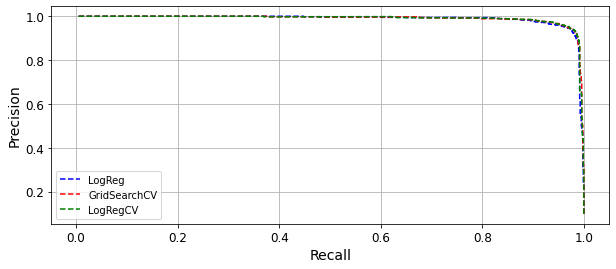

In [61]:
plt.figure(figsize=(10,4))
plt.plot(recalls_lr[:-1], precisions_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precisions_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precisions_lr_cv[:-1], 'g--', label='LogRegCV')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

Note that the PR curves for all three classifiers overlap significantly.

Let's calculate area under the PR curve:

In [62]:
from sklearn.metrics import auc
auc_lr = auc(recalls_lr[:-1], precisions_lr[:-1])
auc_lr_gs = auc(recalls_lr_gs[:-1], precisions_lr_gs[:-1])
auc_lr_cv = auc(recalls_lr_cv[:-1], precisions_lr_cv[:-1])

print ("AUC-PR for logistic regression:", auc_lr)
print ("AUC-PR for grid search:", auc_lr_gs)
print ("AUC-PR for logistic regression CV:", auc_lr_cv)

AUC-PR for logistic regression: 0.9871337497759658
AUC-PR for grid search: 0.9886520703587929
AUC-PR for logistic regression CV: 0.9886326829687666


Observe that the AUC for all three classifier is roughly the same with LogisticRegression
classifier obtained through cross validation and grid search have slightly higher AUC under PR
curve.

# Confusion matrix

We show a confusion matrix for test set with logistic regression classifier:

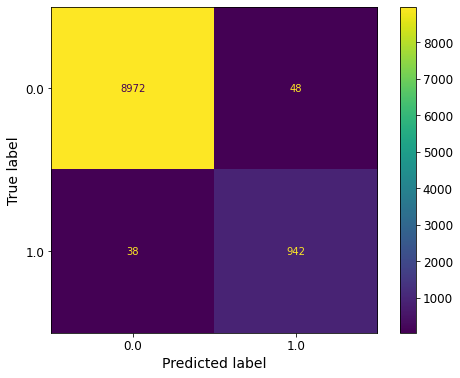

In [63]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,lr_y_hat_0,values_format='.5g')

# it return matplotlin plot object
plt.show()

Confusion matrix for test set with logistic regression classifier obtained through grid search:

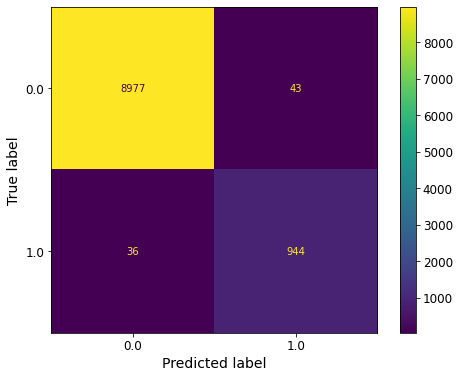

In [64]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,lr_gs_y_hat_0,
values_format='.5g')

# it return matplotlin plot object
plt.show()

Confusion matrix for test set with logistic regression classifier obtained through cross
validation:

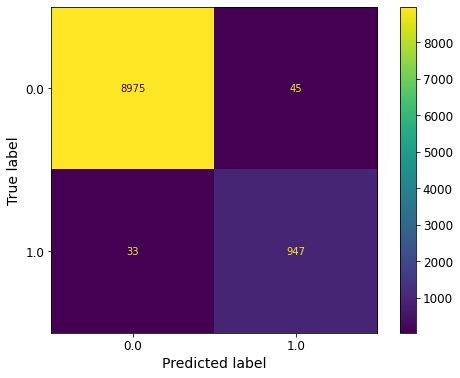

In [65]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,lr_cv_y_hat_0,
values_format='.5g')

# it return matplotlin plot object
plt.show()